In [1]:
from transformers import AutoTokenizer

/Volumes/AccelWorld/opt/anaconda3/envs/seka/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/Volumes/AccelWorld/opt/anaconda3/envs/seka/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch, gc, seaborn as sns, matplotlib.pyplot as plt
import sys  
sys.path.insert(1, '../')
from src.model import SEKALLM                     # ← your new wrapper
from src.utils   import encode_with_markers            # unchanged

# ---------- 1. prompt -------------------------------------------------
tok      = AutoTokenizer.from_pretrained('../pretrained/Qwen3-1.7B-Base')
ks = SEKALLM("../pretrained/Qwen3-1.7B-Base", output_attentions=True)

In [12]:
prompt = (
    "Irrelevant tokens\n"
    "**Highlighted tokens**"
)
ids, msk, _ = encode_with_markers(prompt, tok)        # ids:(1,seq)  msk:(seq,)
ids      = ids.to("mps");  device = ids.device

ks.remove_projection()

with torch.no_grad():
    base_out  = ks.model(ids, output_attentions=True, use_cache=False)
base_attn = [l.detach().cpu() for l in base_out.attentions]

# ---------- 3. inject φ‑space K‑projection ---------------------------
ks.attach_projection(
    pos_pt="../projections/synthetic_new/Qwen3-1.7B-Base_pos_proj.pt",
    neg_pt="../projections/synthetic_new/Qwen3-1.7B-Base_neg_proj.pt",
    layers="all",
    steer_mask_tensor=msk,
    amplify_pos=0.5,                # tune as needed
    amplify_neg=0.3,                # tune as needed
    # feature_function="squared-exponential"
)

with torch.no_grad():
    steer_out = ks.model(ids, output_attentions=True, use_cache=False)
steer_attn = [l.detach().cpu() for l in steer_out.attentions]

gc.collect()
print("✓ collected baseline and steered attentions")

✅ Steering hooks attached on layers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
✓ collected baseline and steered attentions


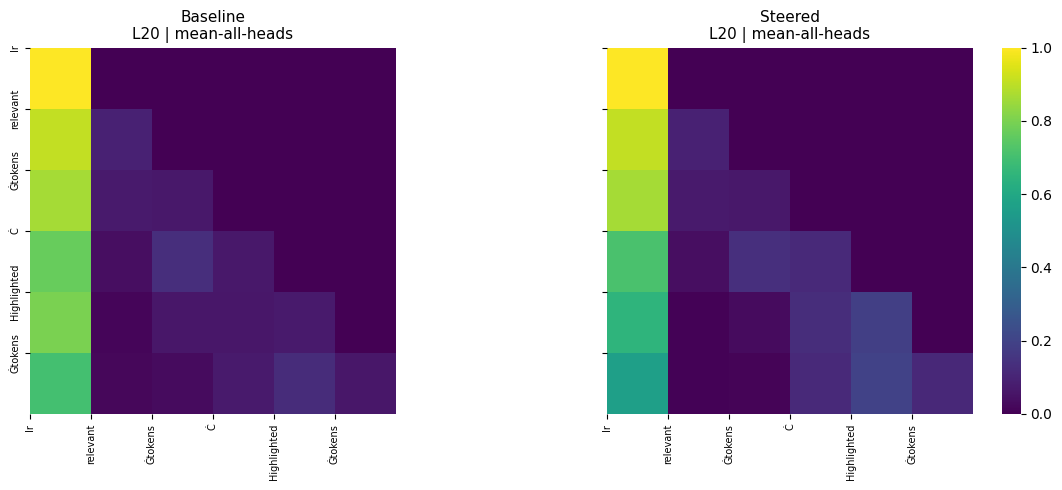

In [14]:
# ---------- 4. visual helper -----------------------------------------
def show_pair(b_attn, s_attn, layer:int, head:int|None=None, vmax:float|None=None):
    B = b_attn[layer][0];  S = s_attn[layer][0]        # (H,T,T)

    if head is None:
        B = B.mean(0);  S = S.mean(0);  ttl = f"L{layer} | mean‑all‑heads"
    else:
        B = B[head];     S = S[head];    ttl = f"L{layer}, H{head}"

    vmax = float(max(B.max(), S.max())) if vmax is None else vmax
    tokens = tok.convert_ids_to_tokens(ids[0].tolist())

    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    for i,(mat,title) in enumerate(zip([B,S],["Baseline","Steered"])):
        sns.heatmap(mat.numpy(), ax=ax[i], cmap="viridis",
                    vmin=0, vmax=vmax, cbar=i==1, square=True)
        ax[i].set_title(f"{title}\n{ttl}", fontsize=11)
        ax[i].set_xticks(range(len(tokens))); ax[i].set_xticklabels(tokens, rotation=90, fontsize=7)
        ax[i].set_yticks(range(len(tokens))); ax[i].set_yticklabels(tokens, fontsize=7)
    plt.tight_layout();  plt.show()

# ---------- 5. example ------------------------------------------------
show_pair(base_attn, steer_attn, layer=20, head=None)   # avg heads
# show_pair(base_attn, steer_attn, layer=18, head=5)    # one head